# Data report for the Shmushkovich et al. dataset on siRNA efficacy.

This dataset was sourced from https://doi.org/10.1093/nar/gky745. A study by Shmushkovich et al. that aimed to develop a model to predict the efficacy of cholesterol conjugated siRNAs. The data is obtained with a dual reporter luminescence assay on transfected HeLa cells.

The data provided by the authors only contains the target sequence of each siRNA, based on the description in the text it is possible to reconstruct the modified siRNA sequences, but the information is not complete. In the cases in which the sugar modification could not be deducted with certainty we kept a natural ribose. In the helm provided we do not include the conjugates, since they are the same across all sequences, they should not impact any learning.

In [1]:
from oligogym.data import DatasetDownloader
from oligogym.stats import get_cosine_dist_to_nearest_neighbor, get_outliers
from oligogym.features import KMersCounts
from oligogym.models import RandomForestModel
from oligogym.metrics import regression_metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


## Processed dataset

In [2]:
downloader = DatasetDownloader()
dataset = downloader.download("siRNA3")
dataset.data

,x,y,y_raw,targets,smiles,fasta
0,RNA1{r(U)p.r(U)p.m(A)p.m(A)p.m(A)p.r(C)p.m(A)p...,17.10,17.10,NaN,CO[C@@H]1[C@H](OP(=O)(O)OC[C@H]2O[C@@H](n3ccc(...,UUAAACAGAUGUGAA.UUCACAUCUGUUUAAUGUGC
1,RNA1{m(A)p.m(A)p.r(U)p.m(G)p.m(A)p.m(A)p.m(G)p...,6.50,6.50,NaN,CO[C@@H]1[C@H](OP(=O)(O)OC[C@H]2O[C@@H](n3ccc(...,AAUGAAGGUAUUUAA.UUAAAUACCUUCAUUAGAUC
2,RNA1{r(U)p.m(G)p.r(U)p.r(U)p.r(U)p.r(U)p.m(G)p...,3.49,3.49,NaN,CO[C@@H]1[C@H](OP(=O)(O)OC[C@H]2O[C@@H](n3ccc(...,UGUUUUGUGAGGUAA.UUACCUCACAAAACAAAGCA
3,RNA1{r(C)p.m(A)p.r(U)p.m(G)p.r(U)p.m(A)p.r(U)p...,4.61,4.61,NaN,CO[C@@H]1[C@H](OP(=O)(O)OC[C@H]2O[C@@H](n3ccc(...,CAUGUAUCUACUUGA.UCAAGUAGAUACAUGCCAAC
4,RNA1{m(G)p.m(G)p.m(A)p.m(A)p.m(G)p.m(A)p.r(U)p...,5.07,5.07,NaN,CO[C@@H]1[C@H](OP(=O)(O)OC[C@H]2O[C@@H](n3ccc(...,GGAAGAUAAACAAAA.UUUUGUUUAUCUUCCUCCUU
...,...,...,...,...,...,...
351,RNA1{m(G)p.m(G)p.r(C)p.m(A)p.m(G)p.m(A)p.m(A)p...,109.21,109.21,NaN,CO[C@@H]1[C@H](OP(=O)(O)OC[C@H]2O[C@@H](n3ccc(...,GGCAGAAGCUAUGAA.UUCAUAGCUUCUGCCAGCCG
352,RNA1{r(C)p.r(U)p.m(G)p.m(A)p.m(A)p.m(A)p.r(U)p...,109.88,109.88,NaN,CO[C@@H]1[C@H](OP(=O)(O)OC[C@H]2O[C@@H](n3ccc(...,CUGAAAUUAUUUAAA.UUUAAAUAAUUUCAGGAAUG
353,RNA1{r(U)p.r(C)p.r(C)p.r(U)p.m(G)p.m(A)p.m(A)p...,113.42,113.42,NaN,CO[C@@H]1[C@H](OP(=O)(O)OC[C@H]2O[C@@H](n3cnc4...,UCCUGAAAUUAUUUA.UAAAUAAUUUCAGGAAUGGG
354,RNA1{m(A)p.m(A)p.m(G)p.r(U)p.r(U)p.m(A)p.r(U)p...,116.70,116.70,NaN,CO[C@@H]1[C@H](OP(=O)(O)OC[C@H]2O[C@@H](n3cnc4...,AAGUUAUACUUCACA.UGUGAAGUAUAACUUCACCU


## Features statistics

In [3]:
dataset.get_helm_stats()

,avg_nt_seq_len,combined_unique_monomers,avg_GC_content,avg_G_content,avg_C_content,avg_A_content,avg_TU_content,num_duplicates
0,17.5,"[A, C, G, U, fl2r, m, p, r, sp]",35.404963,17.530431,26.639747,33.595506,30.999532,0


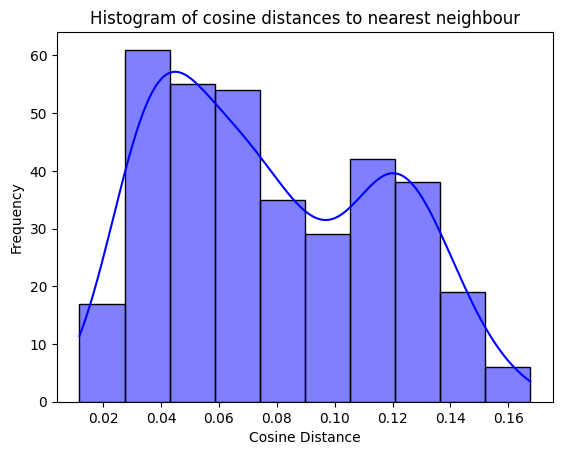

In [4]:
cosine_distances = get_cosine_dist_to_nearest_neighbor(dataset.x)

fig, ax = plt.subplots()

sns.histplot(cosine_distances, ax=ax, color='blue', kde=True)

ax.set_title('Histogram of cosine distances to nearest neighbour')
ax.set_xlabel('Cosine Distance')
ax.set_ylabel('Frequency')

plt.show()

In [5]:
number_similar_sequences=np.sum(cosine_distances == 0)
print(f"{number_similar_sequences} ASOs have cosine distance to NN of zero when measured using 1 to 5 mers frequency count")

0 ASOs have cosine distance to NN of zero when measured using 1 to 5 mers frequency count


In [6]:
X_train, X_test, y_train, y_test = dataset.split(split_strategy="random", random_state=42)
cosine_dist_nucleobase = get_cosine_dist_to_nearest_neighbor(X_train, X_test)

X_train, X_test, y_train, y_test = dataset.split(split_strategy="nucleobase", random_state=42)
cosine_dist_random = get_cosine_dist_to_nearest_neighbor(X_train, X_test)

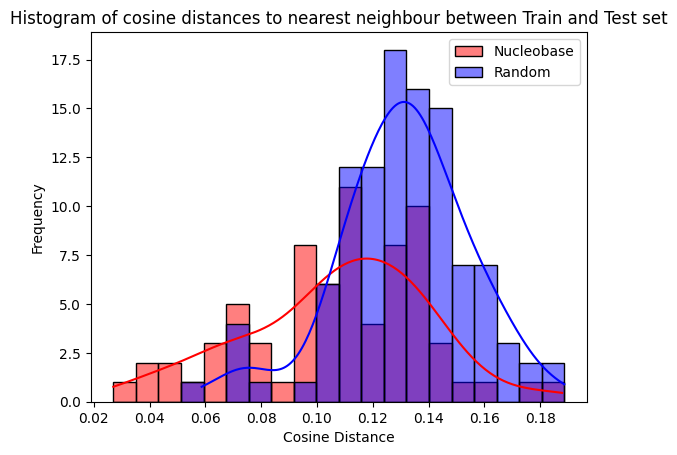

In [7]:
data_min = min(min(cosine_dist_random), min(cosine_dist_nucleobase))
data_max = max(max(cosine_dist_random), max(cosine_dist_nucleobase))

num_bins = 20
bin_edges = np.linspace(data_min, data_max, num_bins+1)

fig, ax = plt.subplots()

sns.histplot(cosine_dist_nucleobase, ax=ax, color='red', kde=True, label='Nucleobase', bins=bin_edges)
sns.histplot(cosine_dist_random, ax=ax, color='blue', kde=True, label='Random', bins=bin_edges)

ax.set_title('Histogram of cosine distances to nearest neighbour between Train and Test set')
ax.set_xlabel('Cosine Distance')
ax.set_ylabel('Frequency')

ax.legend()
plt.show()

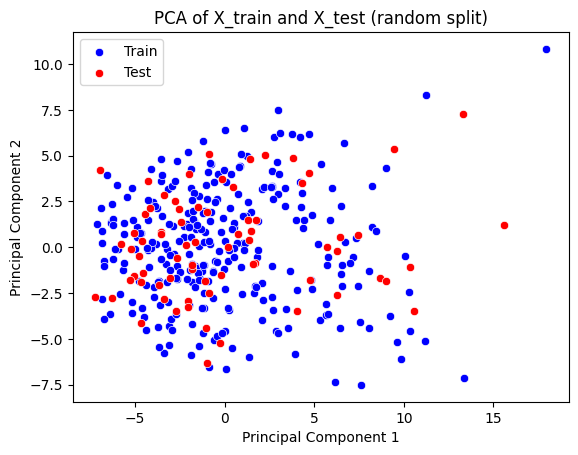

In [8]:
X_train, X_test, y_train, y_test = dataset.split(split_strategy="random", random_state=42)
cosine_dist_nucleobase = get_cosine_dist_to_nearest_neighbor(X_train, X_test)

featurizer = KMersCounts(k=[1, 2, 3])
X_train = featurizer.fit_transform(X_train)
X_test = featurizer.transform(X_test)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

fig, ax = plt.subplots()
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], ax=ax, color='blue', label='Train')
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], ax=ax, color='red', label='Test')

ax.set_title('PCA of X_train and X_test (random split)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.legend()

plt.show()

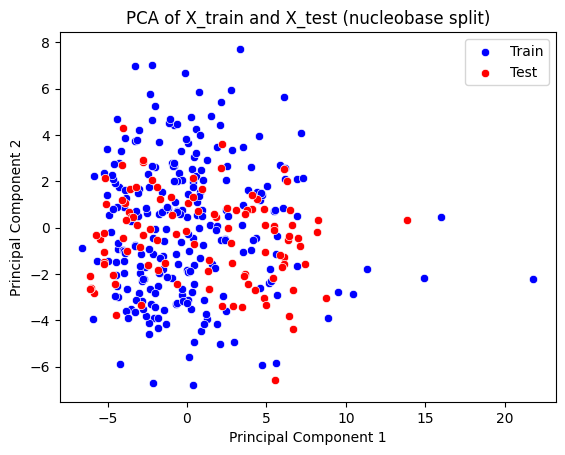

In [9]:
X_train, X_test, y_train, y_test = dataset.split(split_strategy="nucleobase", random_state=42)
cosine_dist_nucleobase = get_cosine_dist_to_nearest_neighbor(X_train, X_test)

featurizer = KMersCounts(k=[1, 2, 3])
X_train = featurizer.fit_transform(X_train)
X_test = featurizer.transform(X_test)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

fig, ax = plt.subplots()
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], ax=ax, color='blue', label='Train')
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], ax=ax, color='red', label='Test')

ax.set_title('PCA of X_train and X_test (nucleobase split)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.legend()

plt.show()

## Labels statistics

In [10]:
label_stats=dataset.get_label_stats()
label_stats

,nobs,minmax,mean,variance,skewness,kurtosis,num_zeros
0,356,"(3.49, 119.88)",44.238216,597.267089,0.698151,-0.040309,0


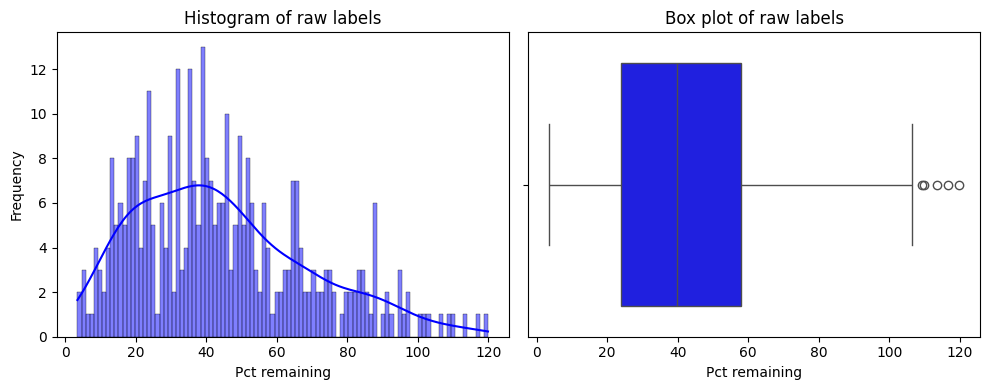

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(dataset.data.y_raw, ax=axs[0], color='blue', kde=True, bins=100)
axs[0].set_title('Histogram of raw labels')
axs[0].set_xlabel('Pct remaining')
axs[0].set_ylabel('Frequency')

sns.boxplot(x=dataset.data.y_raw, ax=axs[1], color='blue')
axs[1].set_title('Box plot of raw labels')
axs[1].set_xlabel('Pct remaining')

plt.tight_layout()
plt.show()

# Clustering analysis

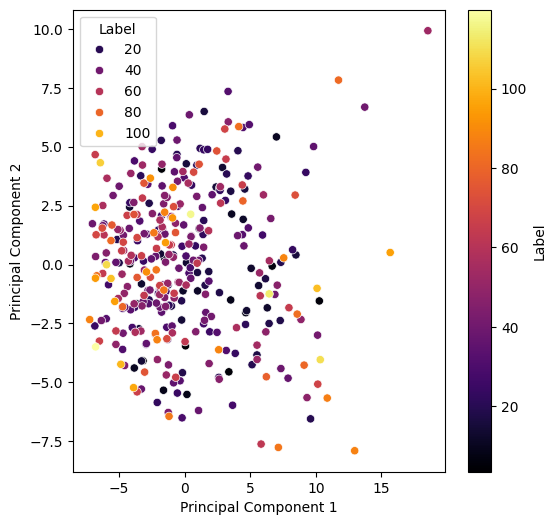

In [12]:
featurizer = KMersCounts(k=[1, 2, 3])
X_kmers = featurizer.fit_transform(dataset.x)

pca = PCA(n_components=2)
X_kmers_pca = pca.fit_transform(X_kmers)

fig, ax = plt.subplots(1 ,1, figsize=(6, 6))
sns.scatterplot(x=X_kmers_pca[:, 0], y=X_kmers_pca[:, 1], hue=dataset.y, ax=ax, palette='inferno')
norm = plt.Normalize(dataset.y.min(), dataset.y.max())
sm = plt.cm.ScalarMappable(cmap="inferno", norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Label')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.legend(title="Label")

plt.show()

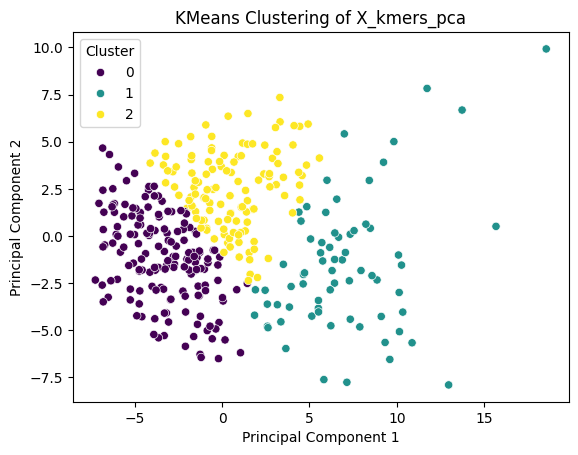

In [13]:
# Perform KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_kmers_pca)

# Plot the clusters
fig, ax = plt.subplots()
sns.scatterplot(x=X_kmers_pca[:, 0], y=X_kmers_pca[:, 1], hue=clusters, palette='viridis', ax=ax)
ax.set_title('KMeans Clustering of X_kmers_pca')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

Let's figure out which features differ the most between the different clusters.

In [14]:
cluster_means = X_kmers.groupby(clusters).mean()
feature_differences = cluster_means.diff().abs().iloc[1]
sorted_feature_differences = feature_differences.sort_values(ascending=False)
print(sorted_feature_differences.head(10))

C      3.615631
A      3.598382
U      3.347915
G      3.330666
UA     2.954121
AA     2.733885
AU     2.554281
UU     2.457100
UAA    1.505913
AAA    1.485018
Name: 1, dtype: float64


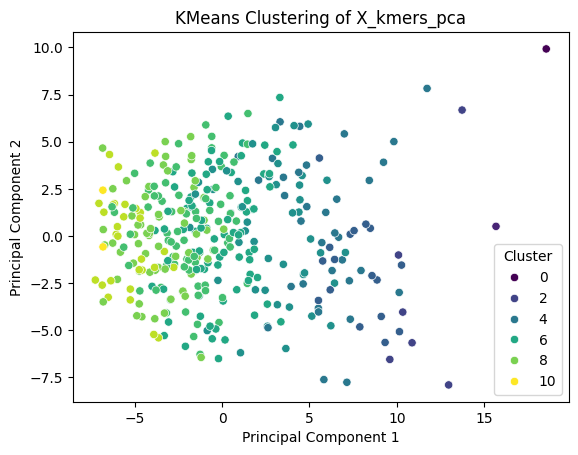

In [15]:
# Plot the clusters
fig, ax = plt.subplots()
sns.scatterplot(x=X_kmers_pca[:, 0], y=X_kmers_pca[:, 1], hue=X_kmers['C'].values, palette='viridis', ax=ax)
ax.set_title('KMeans Clustering of X_kmers_pca')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

We can also do this by looking at the features that are most important for classifying the clusters.

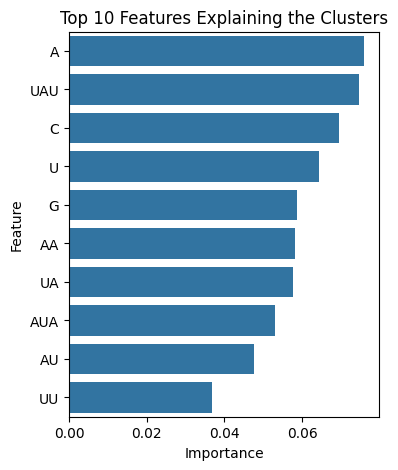

In [16]:
importances = RandomForestClassifier(random_state=42).fit(X_kmers, clusters).feature_importances_

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({'Feature': X_kmers.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(4, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title('Top 10 Features Explaining the Clusters')
plt.show()

# Predictability analysis

In [17]:
X_train, X_test, y_train, y_test = dataset.split(split_strategy="random", random_state=42)
featurizer = KMersCounts(k=[1, 2, 3])
X_train = featurizer.fit_transform(X_train)
X_test = featurizer.transform(X_test)

model = RandomForestModel(task="regression")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
metrics_train = regression_metrics(y_train, y_pred_train)
metrics = regression_metrics(y_test, y_pred)
print(metrics_train)
print(metrics)


{'r2_score': 0.8848517979357133, 'root_mean_squared_error': 8.080922246597515, 'mean_absolute_error': 6.350396654929581, 'pearson_correlation': 0.9760606698600554, 'spearman_correlation': 0.9748169530219167}
{'r2_score': 0.3070135729905097, 'root_mean_squared_error': 22.14681765540136, 'mean_absolute_error': 18.204381944444446, 'pearson_correlation': 0.5859052213085154, 'spearman_correlation': 0.5454253121382767}


## Recommendation for dataset

The sequences seems quite well distributed with no obvious duplicates or outlier.

There are a couple of compounds whose measured percent remaining is higher 100% which indicates some measurement error. These can be removed from the dataset if needed.